# Tutorial 2: Uso avançado da Decomposição Modal Dinâmica

Neste tutorial, mostraremos uma aplicação mais sofisticada do algoritmo padrão de **decomposição modal dinâmica**  Em detalhes, criaremos um conjunto de dados 2D que oscila no tempo e nos concentraremos nos parâmetros que permitem ajustar de forma ideal essa técnica para o sistema estudado. Como o principal objetivo deste tutorial é a introdução das configurações avançadas.


# Importando las bibliotecas de trabajo 

Primeiramente, importamos a classe DMD do pacote pydmd, configuramos o matplotlib para o notebook, importamos numpy e scipy, a função para exibir vídeos HTML no IPython e, por fim, importamos o submódulo de animação do matplotlib.

In [9]:
%matplotlib inline
import numpy as np
import scipy
import scipy.integrate
from matplotlib import animation
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import pyplot as plt
from pydmd import DMD
from pydmd.plotter import plot_modes_2D
import matplotlib.pyplot as plt


# Creando los datos 


Agora, vamos criar o conjunto de dados: obtemos um seno hiperbólico com oscilações amortecidas a partir da seguinte fórmula:

- $f(x,y,t) = \text{senh}(x)\text{senh}(y)1.2\text{i}^{-t}$.

Nós tiramos 16 instantâneos equiespaçados.

Além disso, para tornar os dados de entrada mais realistas, adicionamos algum ruído.

Tamanho: 16
Tipo de Dados: <class 'list'>
El tamanho de la matriz es : (80, 80)


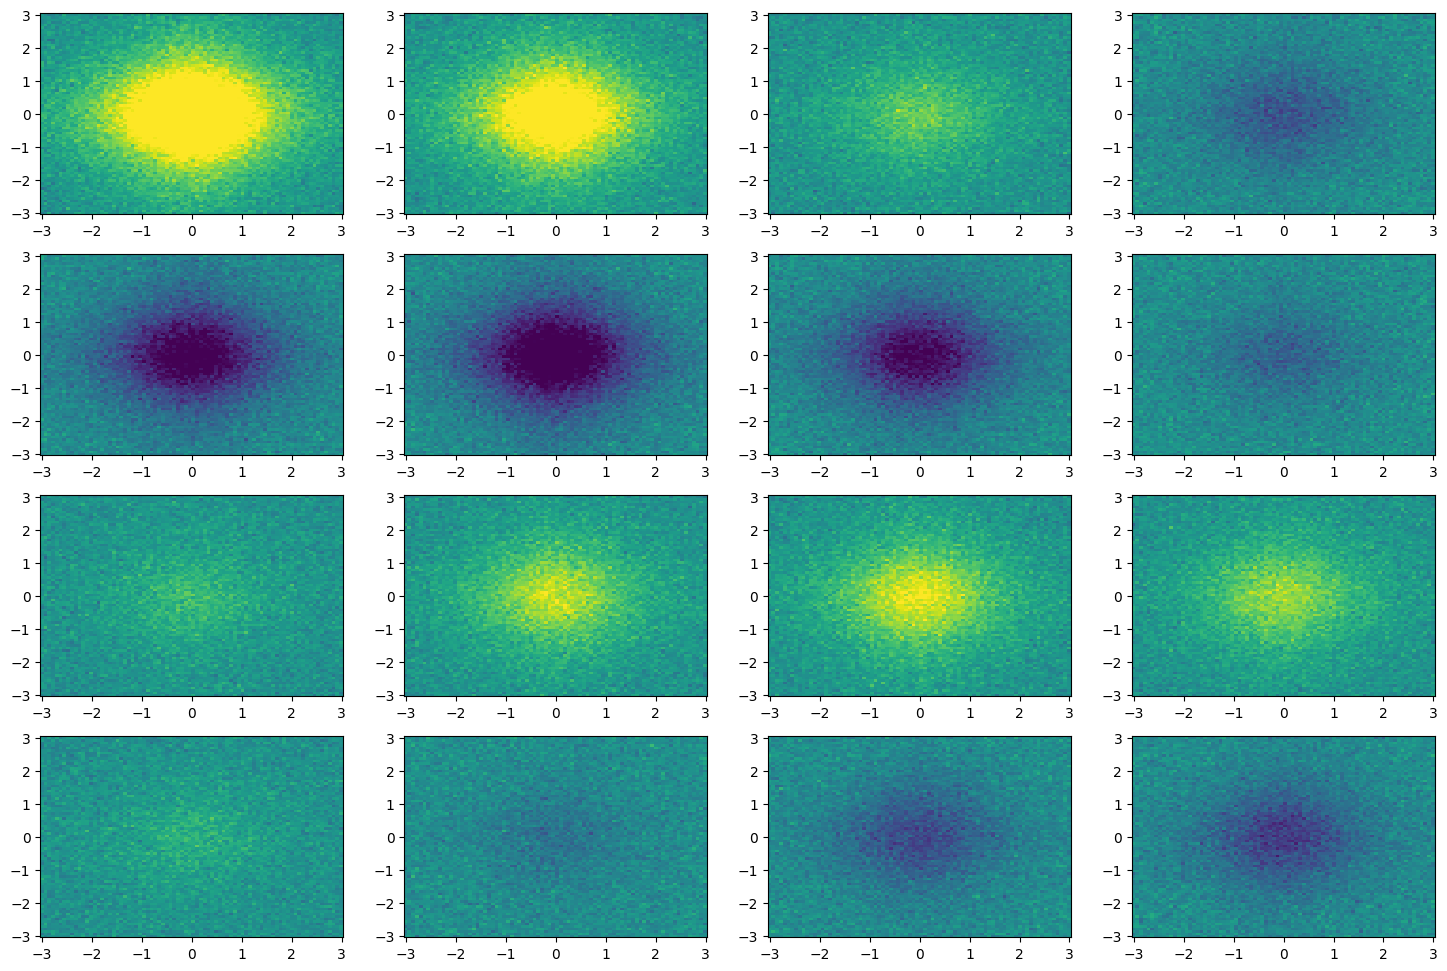

In [10]:
# Cria um array de 80 pontos equidistantes no intervalo [-3, 3] para a coordenada x1.
x1 = np.linspace(-3, 3, 80)
# Cria um array de 80 pontos equidistantes no intervalo [-3, 3] para a coordenada x2.
x2 = np.linspace(-3, 3, 80)

#Cria uma grade bidimensional de coordenadas combinando os arrays x1 e x2

x1grid, x2grid = np.meshgrid(x1, x2)

# Cria um array de 16 pontos para el tiempo
time = np.linspace(0, 6, 16)

# Calcula os dados de acordo com a fórmula dada, onde cada snapshot é calculado para um tempo específico usando a fórmula  
# do seno hiperbólico com oscilações amortecidas

data = [2 / np.cosh(x1grid) / np.cosh(x2grid) * (1.2j**-t) for t in time]

print(f"Tamanho: {len(data)}")
print(f"Tipo de Dados: {type(data)}")

# Crea el ruido que se le va a colocar a los datps 
noise = [np.random.normal(0.0, 0.1, size=x1grid.shape) for t in time]

# Suma el ruido a la base de datos creada (base de datos creada)
# Lista donde se almacenan los resultados como una matriz [80x80]
snapshots = [d + n for d, n in zip(data, noise)]

print(f"El tamanho de la matriz es : {snapshots[0].shape}")

fig = plt.figure(figsize=(18, 12))

# Grafica los 16 snapshot tomados 
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)

Certo, agora é hora de aplicar o DMD aos dados coletados. Primeiro, criamos uma nova instância de `DMD`; observamos que existem quatro parâmetros opcionais:
- `svd_rank` como a decomposição modal dinâmica depende da decomposição de valores singulares, podemos especificar o número dos maiores valores singulares usados para aproximar os dados de entrada.
- `tlsq_rank`: usando o método de quadrados mínimos totais, é possível realizar uma regressão linear para remover o ruído nos dados; como essa regressão é baseada novamente na decomposição de valores singulares, este parâmetro indica quantos valores singulares são usados.
- `exact`: sinalizador booleano que permite escolher entre os modos exatos ou os projetados.
- `opt`: sinalizador booleano que permite escolher entre a versão padrão e a otimizada.

# Aplicando modelo DMD

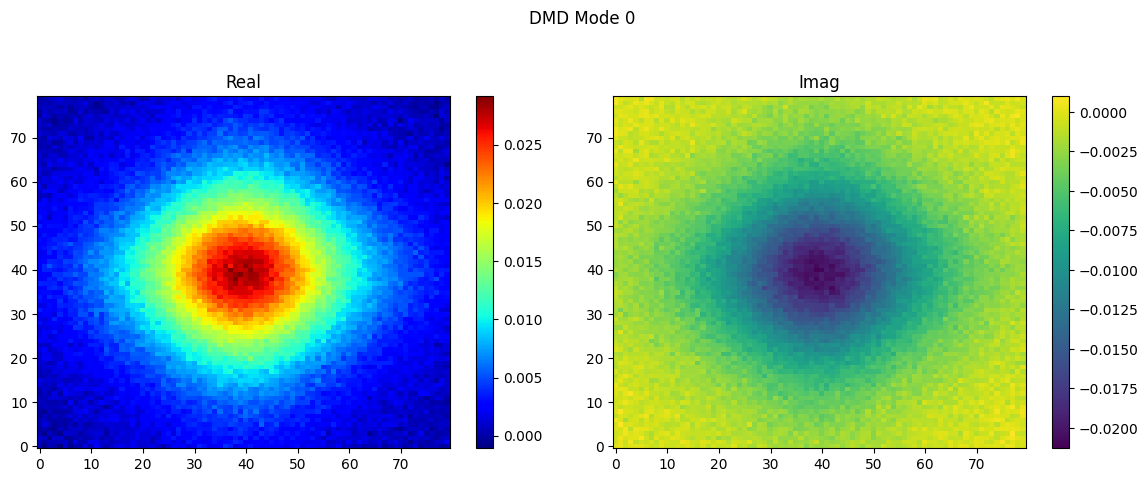

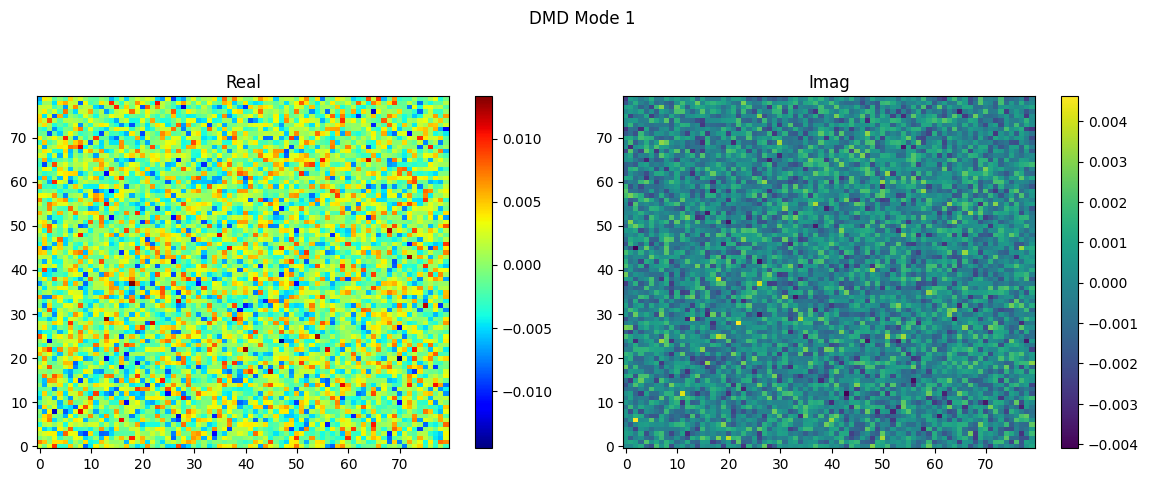

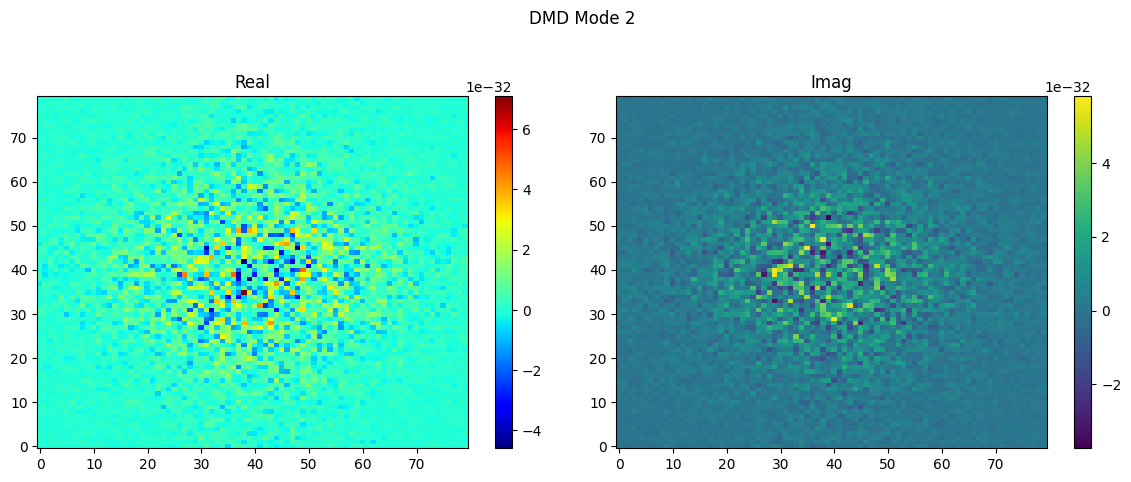

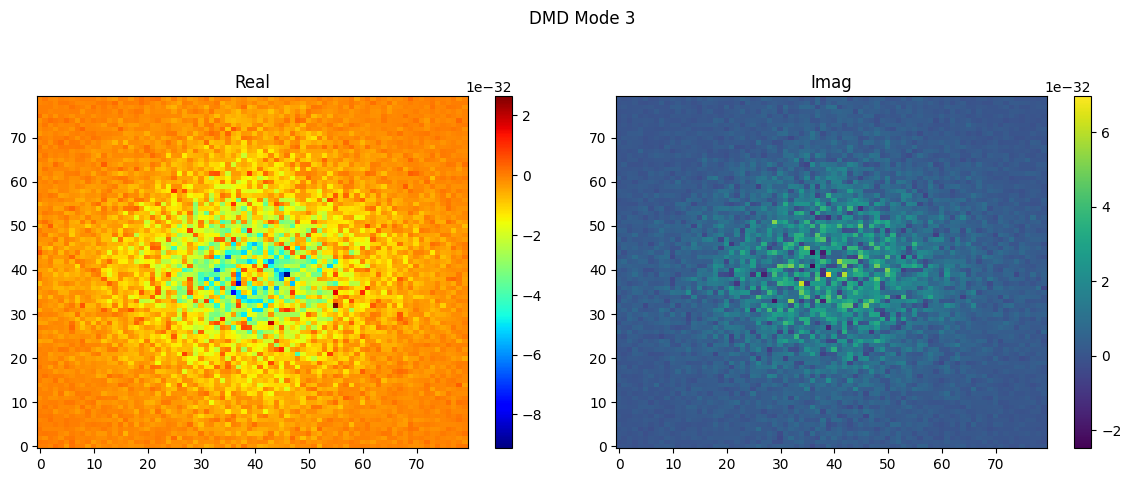

In [11]:
dmd = DMD(svd_rank=0, tlsq_rank=2, exact=True, opt=True,tikhonov_regularization=True)
# Se aplica la descomposicion a cada valor de la lista (Rutina interna)-Los valores ya fueron calculados
dmd.fit(snapshots)
plot_modes_2D(dmd, figsize=(12, 5))


O `svd_rank` pode ser definido como zero para uma seleção automática da classificação de truncamento; em alguns casos (como neste tutorial) os valores singulares devem ser examinados para selecionar o truncamento adequado.

# Analisis por valores singulares 

[135.48596679   8.31764641   8.28658787   8.27126742   8.20204015
   8.16899006   8.11204      8.04246249   8.01527084   7.9562228
   7.90393604   7.86600818   7.79758206   7.74650749   7.70918954
   7.60522486]


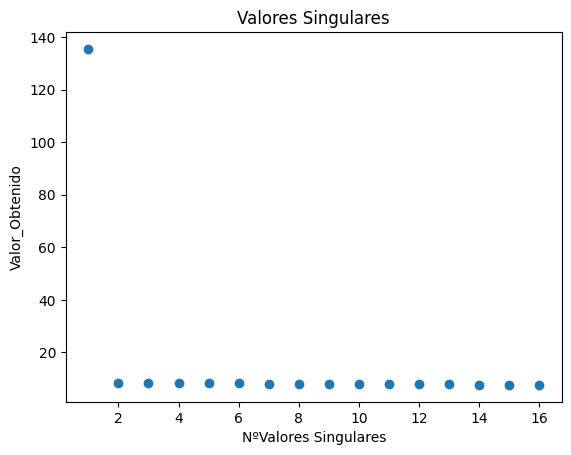

In [12]:

# Convierte una matriz multidimensional en un arreglo unidimensional ()-MI base de datos
Matriz_Datos= (np.array([snapshot.flatten() for snapshot in snapshots]).T)

Valores_singulares=scipy.linalg.svdvals(Matriz_Datos)

print(scipy.linalg.svdvals(Matriz_Datos))

y = np.linspace(1, len(Valores_singulares), len(Valores_singulares))

plt.plot( y,Valores_singulares, "o")

# Agregamos etiquetas y título al gráfico
plt.xlabel("NºValores Singulares")
plt.ylabel("Valor_Obtenido")
plt.title("Valores Singulares")

# Mostramos la gráfica
plt.show()

Podemos agora representar graficamente os estados reconstruídos a partir do DMD: o sistema aproximado é semelhante ao original e, além disso, o ruído é bastante reduzido.

(16, 6400)


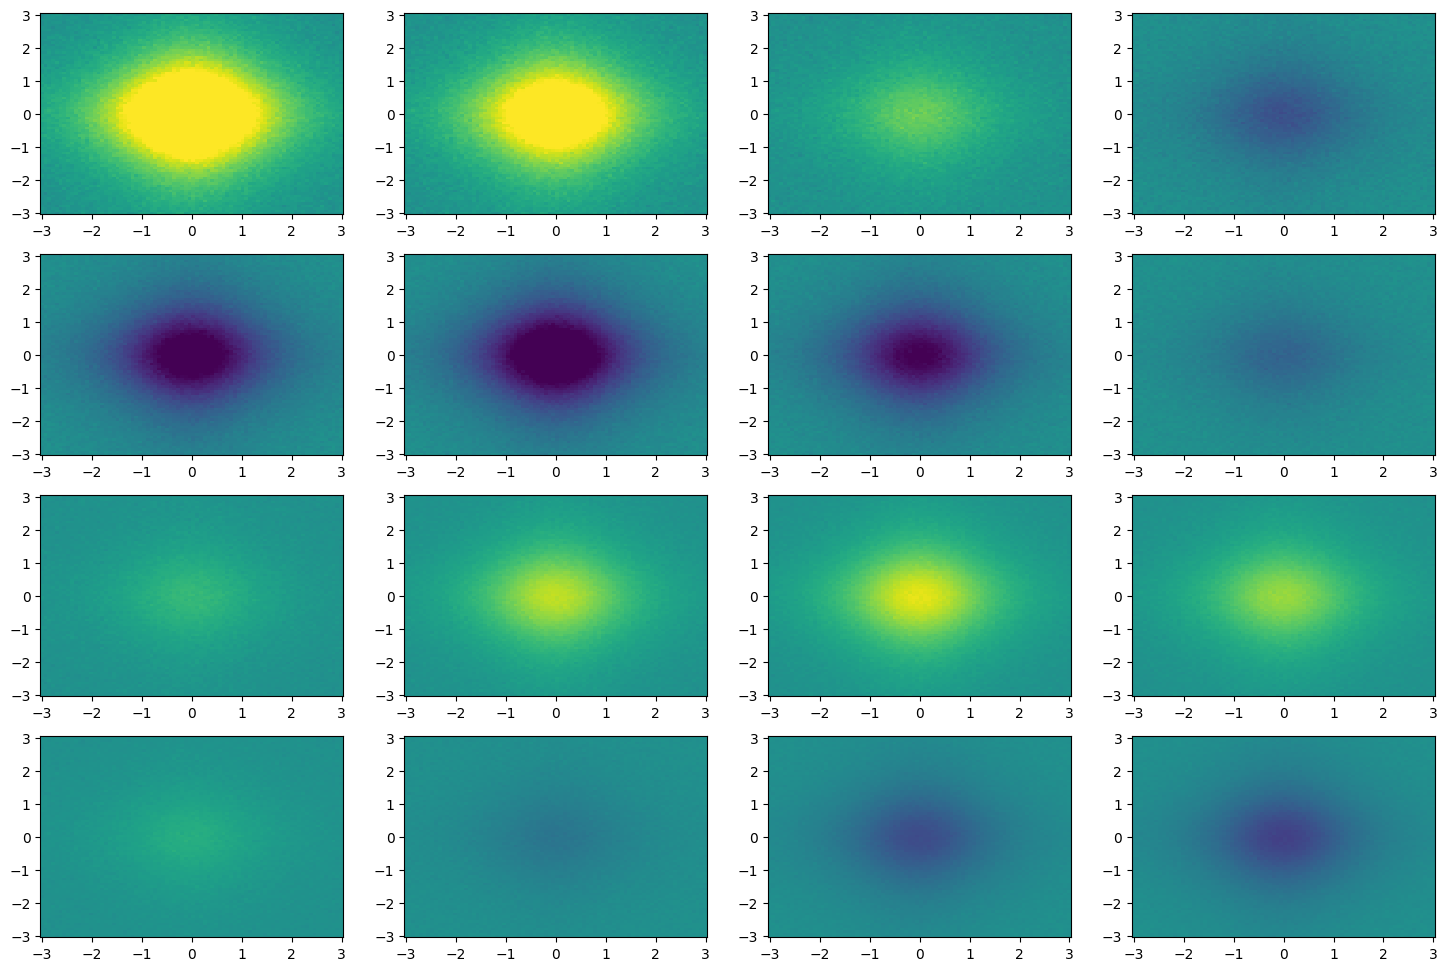

In [13]:
fig = plt.figure(figsize=(18, 12))

print(dmd.reconstructed_data.T.shape)

# La matriz es de (16x6400)
# Contruye los valores deconstruidos por el metodo DMD

for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):

    plt.subplot(4, 4, id_subplot)
    # Cada fila de la matriz dmd.reconstructed_data.T (asociada con todo el espacio a un tiempo det)
    plt.pcolor(
        x1grid, x2grid, snapshot.reshape(x1grid.shape).real, vmin=-1, vmax=1
    )

Também podemos manipular o intervalo entre os estados aproximados e estender a janela temporal onde os dados são reconstruídos graças ao DMD. Vamos tornar o tempo delta do DMD um quarto do original e estender a janela temporal para $[0, 3t_{\text{org}}]$, onde $t_{\text{org}}$ indica o momento em que o último instantâneo foi capturado.

In [6]:
print("Shape before manipulation: {}".format(dmd.reconstructed_data.shape))

#Reduciendo la frecuencia de muestreo de las instantáneas originales

print(type(dmd.dmd_time["t0"]))

dmd.dmd_time["t0"]=10

dmd.dmd_time["dt"] =dmd.dmd_time["dt"]*2

#Aumentando el tiempo de cada una 
dmd.dmd_time["tend"] = 10*dmd.dmd_time["tend"]

print("Shape after manipulation: {}".format(dmd.reconstructed_data.shape))

Shape before manipulation: (6400, 16)
<class 'int'>
Shape after manipulation: (6400, 71)


Agora o truque legal: combinamos o conjunto de dados reconstruído para criar uma animação que mostra a evolução do nosso sistema. Ressaltamos que você precisa do `ffmpeg` instalado para assistir ao vídeo.

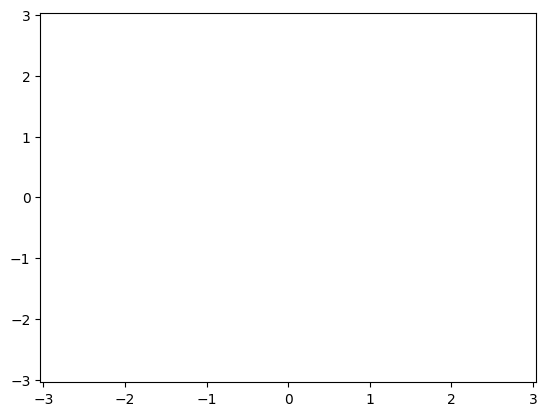

In [7]:

fig = plt.figure()

dmd_states = [state.reshape(x1grid.shape) for state in dmd.reconstructed_data.T]


frames = [
    [plt.pcolor(x1grid, x2grid, state.real, vmin=-1, vmax=1)]
    for state in dmd_states
]


ani = animation.ArtistAnimation(
    fig, frames, interval=70, blit=False, repeat=False
)

HTML(ani.to_html5_video())

Incrível, não é? E lembramos que tudo é obtido apenas a partir de alguns instantâneos barulhentos. Para uma verificação adicional sobre a precisão da reconstrução, podemos representar graficamente a integral calculada nos instantâneos originais e nos estados DMD.

C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_7800\3859891578.py:6: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  compute_integral(compute_integral(snapshot)).real for snapshot in snapshots
C:\Users\Meu Computador\AppData\Local\Temp\ipykernel_7800\3859891578.py:10: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  compute_integral(compute_integral(state)).real for state in dmd_states


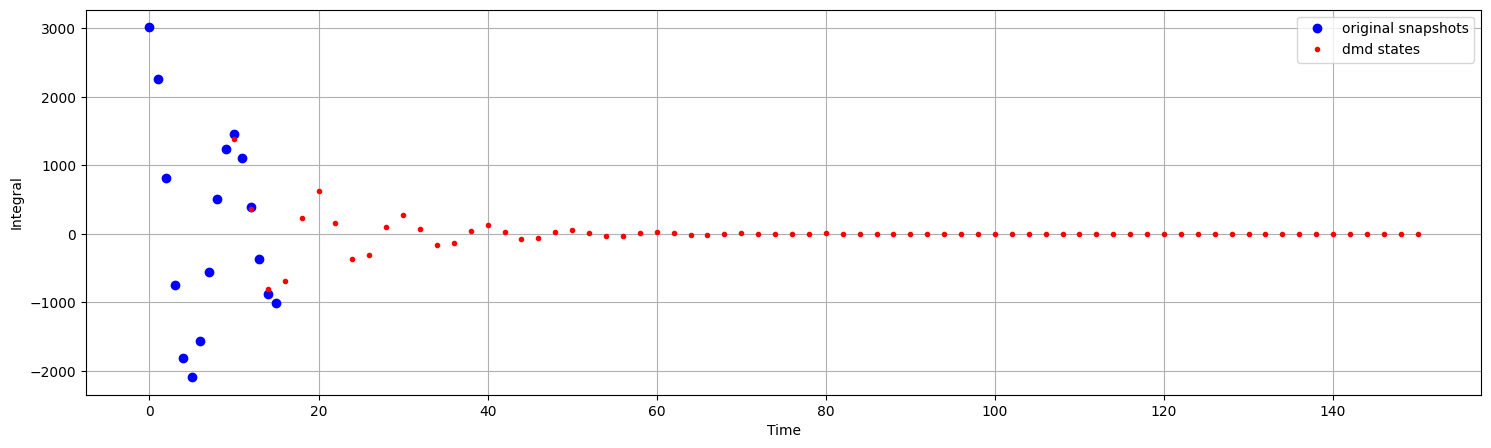

In [8]:
# realizar la integración numérica utilizando el método de los trapecios.

compute_integral = scipy.integrate.trapz

original_int = [
    compute_integral(compute_integral(snapshot)).real for snapshot in snapshots
]

dmd_int = [
    compute_integral(compute_integral(state)).real for state in dmd_states
]

figure = plt.figure(figsize=(18, 5))

plt.plot(dmd.original_timesteps, original_int, "bo", label="original snapshots")


plt.plot(dmd.dmd_timesteps, dmd_int, "r.", label="dmd states")

plt.ylabel("Integral")
plt.xlabel("Time")
plt.grid()
leg = plt.legend()